In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from pathlib import Path
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [3]:
PATH_absolute = pathlib.Path('.').absolute()
PATH_absolute.parents[0]

sys.path.append(f'{PATH_absolute.parents[0]}')

In [4]:
%load_ext autoreload
%autoreload 2
from ROIClassifier import augmentation, cv, loading

stat file loaded

Number of ROIs: 4868
stat file loaded

Number of ROIs: 4847
stat file loaded

Number of ROIs: 4893
stat file loaded

Number of ROIs: 4898
labels file loaded

Number of ROIs: 4868
number of labels and images match
labels file loaded

Number of ROIs: 4847
number of labels and images match
labels file loaded

Number of ROIs: 4893
number of labels and images match
labels file loaded

Number of ROIs: 4898
number of labels and images match


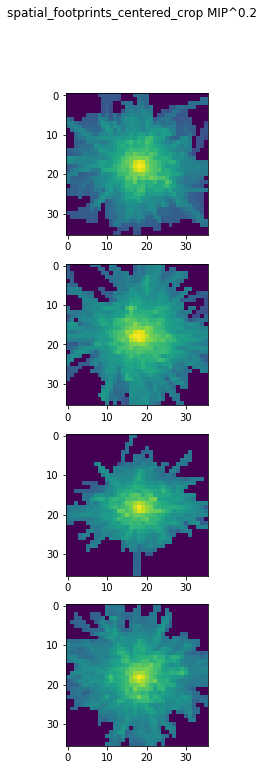

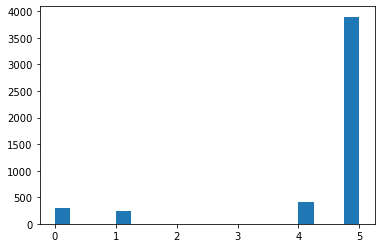

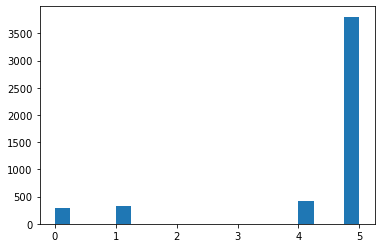

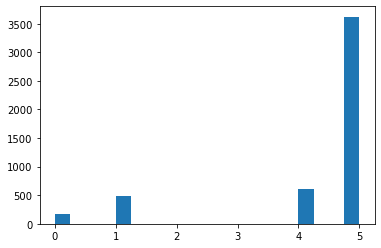

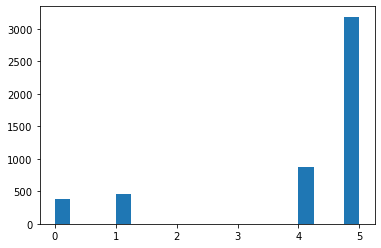

In [7]:
dir_name = '/Users/josh/Documents/Harvard/label_data'
path_list = list([
    Path(f'{dir_name}/mouse 6_28 _ day 20200903'),
    Path(f'{dir_name}/mouse6_28 _ day20200815'),
    Path(f'{dir_name}/mouseUnknownAi148__20210325'),
    Path(f'{dir_name}/mouse2_6__20210409'),
])



images = loading.load_stat_and_make_spatialFootprints(path_list, stat_fileName='stat.npy', preCrop_length=241, crop_length=36, plot_pref=True)
labels = loading.load_labels(path_list, images, label_fileName='label', fileName_is_prefix=True, plot_pref=True)

train_x, val_x, train_y, val_y, train_idx, val_idx,    train_x_all, val_x_all, train_y_all, val_y_all = cv.cv_split_datasets(images,
                                                                                                                          labels,
                                                                                                                          test_fraction=0.15,
                                                                                                                          rand_seed=None)

In [8]:
# torch.cuda.current_device()

In [9]:
# torch.cuda.get_device_name(0)

In [10]:
dup_num = 1

Load and preprocess stat file and labels  
Labels must be made in the 'ROI_labeling_and_augmentation' script and the relabeling script  
## outputs: 'images' and 'labels' (both input into CNN)


In [11]:
def load_npy(base_dir='label_data', subpath='mouse 6_28 _ day 20200903', lbl=''):
    
    # dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
    fileName_load = 'stat.npy'

    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    # PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
    print('stat file loaded')
    print('')

    num_ROI = stat.shape[0]
    print(f'Number of ROIs: {num_ROI}')

    height = 512
    width = 1024
    spatial_footprints_centered = np.zeros((num_ROI, 241,241))
    for i in range(num_ROI):
        spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
    spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

    # %matplotlib inline
    plt.figure()
    plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
    plt.title(f'spatial_footprints_centered_crop{lbl} MIP^0.2');

    images = spatial_footprints_centered_crop
    return spatial_footprints_centered_crop

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/stat.npy

stat file loaded

Number of ROIs: 4868


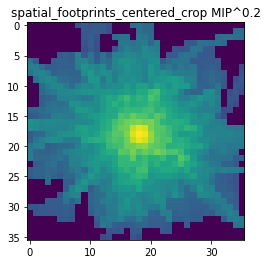

In [12]:
# LOAD stat.npy file 1
#___________________


spatial_footprints_centered_crop = load_npy(base_dir='../../label_data', subpath='mouse 6_28 _ day 20200903')
images = spatial_footprints_centered_crop


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/stat.npy

stat file loaded

Number of ROIs: 4847


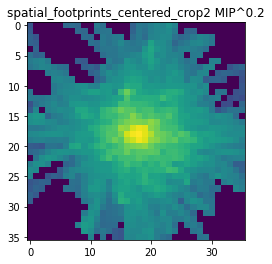

In [13]:
# # LOAD stat.npy file 2
# #___________________


spatial_footprints_centered_crop2 = load_npy(base_dir='../../label_data',
                                             subpath='mouse6_28 _ day20200815',
                                             lbl='2'
                                            )
images2 = spatial_footprints_centered_crop2


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/stat.npy

stat file loaded

Number of ROIs: 4893


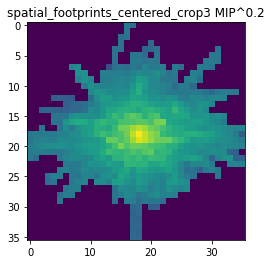

In [14]:
spatial_footprints_centered_crop3 = load_npy(base_dir='../../label_data',
                                             subpath='mouseUnknownAi148__20210325',
                                             lbl='3')
images3 = spatial_footprints_centered_crop3


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/stat.npy

stat file loaded

Number of ROIs: 4898


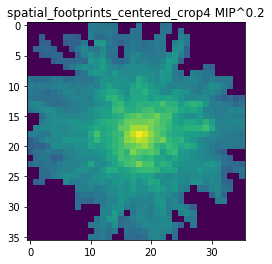

In [15]:
spatial_footprints_centered_crop4 = load_npy(base_dir='../../label_data',
                                             subpath='mouse2_6__20210409',
                                             lbl='4')
images4 = spatial_footprints_centered_crop4


In [16]:
images1 = spatial_footprints_centered_crop
images2 = spatial_footprints_centered_crop2


In [17]:
def load_labels(base_dir='../../label_data',
                 subpath='mouse 6_28 _ day 20200903',
                 fileName_load='labels_posthoc_filledIn_allCells.npy',
                 num_labels=6):
    
    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
    print('labels file loaded')
    print('')


    plt.figure()
    # plt.hist(labels,20);
    plt.hist(labels1,20);


    #check in number of labels matches number of images
    if images.shape[0] == len(labels1):
        print('number of labels and images match')
    else:
        print('WARNING: number of labels and images DO NOT match')
    
    return labels1

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy

labels file loaded

number of labels and images match


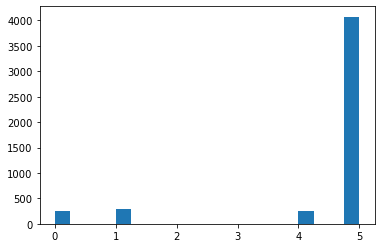

In [18]:
# # LOAD labels file 1
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
# fileName_load = 'labels_posthoc_filledIn_allCells.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels1,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels1):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')


labels1 = load_labels(base_dir='../../label_data',
            subpath='mouse 6_28 _ day 20200903',
            fileName_load='labels_posthoc_filledIn_allCells.npy',
            num_labels=6)

In [19]:
images.shape, labels1.shape

((4868, 36, 36), (4868,))

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/labels_posthoc_all.npy

labels file loaded



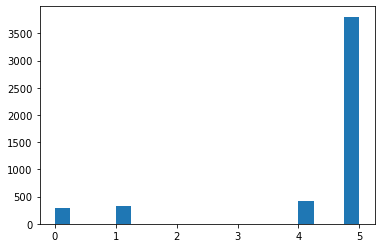

In [20]:
# # LOAD labels file 2
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
# fileName_load = 'labels_posthoc_all.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels2,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels2):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')
    
    
    
labels2 = load_labels(base_dir='../../label_data',
            subpath='mouse6_28 _ day20200815',
            fileName_load='labels_posthoc_all.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/labels_posthoc_mouseUnknownAi148__20210325.npy

labels file loaded



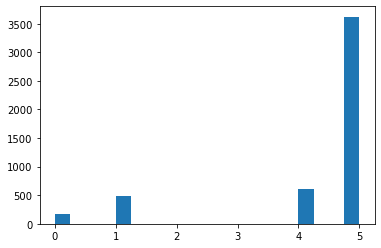

In [21]:
labels3 = load_labels(base_dir='../../label_data',
            subpath='mouseUnknownAi148__20210325',
            fileName_load='labels_posthoc_mouseUnknownAi148__20210325.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/labels_posthoc_mouse2_6__20210409.npy

labels file loaded



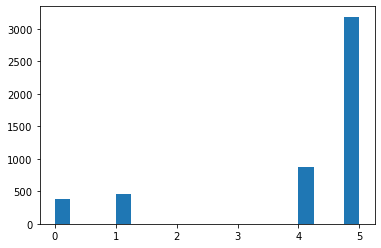

In [22]:
labels4 = load_labels(base_dir='../../label_data',
            subpath='mouse2_6__20210409',
            fileName_load='labels_posthoc_mouse2_6__20210409.npy',
            num_labels=6)

In [23]:
seed = 465
np.random.seed(seed)


# create validation set
train_x_i1, val_x_i1, train_y_i1, val_y_i1 = train_test_split(images1[:], labels1[:], test_size = 0.15)
train_x_i2, val_x_i2, train_y_i2, val_y_i2 = train_test_split(images2[:], labels2[:], test_size = 0.15)
train_x_i3, val_x_i3, train_y_i3, val_y_i3 = train_test_split(images3[:], labels3[:], test_size = 0.15)
train_x_i4, val_x_i4, train_y_i4, val_y_i4 = train_test_split(images4[:], labels4[:], test_size = 0.15)

# train_x, train_y = images, labels
# tea_x, tea_y = images3, labels3
# teb_x, teb_y = images4, labels4
# (train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (tea_x.shape, tea_y.shape), (teb_x.shape, teb_y.shape)



images = np.concatenate((train_x_i1, train_x_i2, train_x_i3, train_x_i4) , axis = 0)
print(images.shape)

train_x = images

labels = np.concatenate((train_y_i1, train_y_i2, train_y_i3, train_y_i4))
print(labels.shape)

train_y = labels

val_x = np.concatenate((val_x_i1, val_x_i2, val_x_i3, val_x_i4) , axis = 0)
val_y = np.concatenate((val_y_i1, val_y_i2, val_y_i3, val_y_i4))

np.save('../../ROI-trash/temp_images.npy', images)
np.save('../../ROI-trash/temp_labels.npy', labels)


(16578, 36, 36)
(16578,)


In [24]:
# importing the libraries
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, ELU, PReLU, Softplus, Softmax2d, AvgPool2d, Tanh
from torch.optim import Adam, SGD

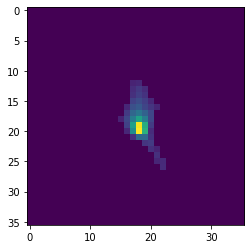

In [33]:
plt.imshow(train_x[300])

In [171]:
# transforms.Compose([
#     transforms.CenterCrop(10),
#     transforms.PILToTensor(),
#     transforms.ConvertImageDtype(torch.float),
# ])


# Transformations to use
from torchvision import transforms

In [172]:
affine = transforms.RandomAffine(180, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15)


transformation_list = [affine]


RandomAffine(degrees=[-180.0, 180.0], translate=(0.1, 0.1), scale=(0.9, 1.1), shear=[-15.0, 15.0])

In [42]:
import simclr

# @markdown Import modules designed for use in this tutorials
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util


In [43]:
# 1. Load Data
# 2. Define torch DataSet
# 3. Define data augmentations
# 4. Create datset with augmentations
# 5. Define SimCLR Object
# 6. Train SimCLR Object with augmented DataSet


In [53]:
class Empty():
    def __init__(self):
        pass

In [61]:
from torch.optim import Adam
from torch.optim import lr_scheduler

In [163]:
# https://github.com/sthalles/SimCLR/blob/1848fc934ad844ae630e6c452300433fe99acfd9/simclr.py
model = simclr.Net()

args = Empty()
args.device = 'cpu'
args.fp16_precision = True
args.epochs = 5
args.disable_cuda = True
args.n_views = 2
args.batch_size=32
args.temperature=1
args.log_every_n_steps=10

optimizer = Adam(model.parameters())
scheduler = lr_scheduler.ExponentialLR(optimizer, 0.01)
sc = simclr.SimCLR(args=args, model=model, optimizer=optimizer, scheduler=scheduler)

In [164]:
dl, ds, smpl = simclr.make_WindowedDataloader(train_x[:,None,:,:], train_y, batch_size=args.batch_size, drop_last=True)


In [165]:
sc.train(dl)

100%|██████████| 518/518 [00:14<00:00, 34.57it/s]


In [166]:
emb = model.get_embedding(torch.tensor(train_x[:,None,:,:])).squeeze()

In [167]:
emb = emb.detach().numpy()

In [168]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embpca = pca.fit_transform(emb)
embpca

array([[-0.2257182 ,  0.26749656],
       [-0.31900692, -0.39455912],
       [ 0.3828511 , -0.4574791 ],
       ...,
       [-0.3524622 , -0.3902284 ],
       [ 0.44613862,  0.22666764],
       [-0.24667513,  0.29164225]], dtype=float32)

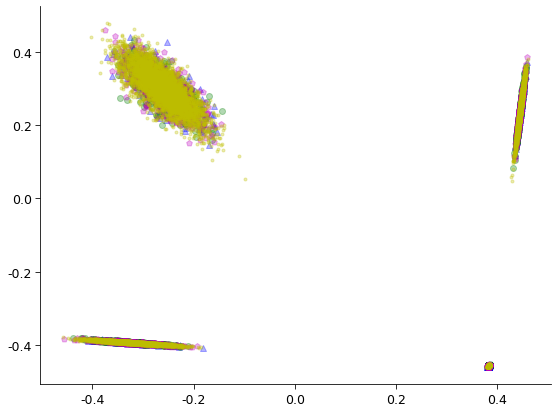

In [169]:
markers = ['^', 'o', 's', 'v', 'p', '.', '.']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for im, marker in enumerate(markers):
    lc = np.where(train_y.astype(int)==im)
    plt.scatter(embpca[lc,0], embpca[lc,1], marker=marker, color=colors[im], alpha=0.3)

In [170]:
sc.writer.close()